In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

intakes = pd.read_csv('Austin_Animal_Center_Intakes.csv')
outcomes = pd.read_csv('Austin_Animal_Center_Outcomes.csv')

In [2]:
#Eliminamos IDs Duplicados

intakes.drop_duplicates(subset=['Animal ID'], keep='first', inplace=True)
outcomes.drop_duplicates(subset=['Animal ID'], keep='first', inplace=True)

#Convertimos los datos referentes a fechas en valores DATETIME

intakes['DateTime'] = pd.to_datetime(intakes['DateTime'])
outcomes['DateTime'] = pd.to_datetime(outcomes['DateTime'])
intakes['MonthYear'] = pd.to_datetime(intakes['MonthYear'])
outcomes['MonthYear'] = pd.to_datetime(outcomes['MonthYear'])
outcomes['Date of Birth'] = pd.to_datetime(outcomes['Date of Birth'])

# Procedemos a unir los Datasets.

data = pd.merge(intakes, outcomes, on='Animal ID', suffixes=('_Intake', '_Outcome'))

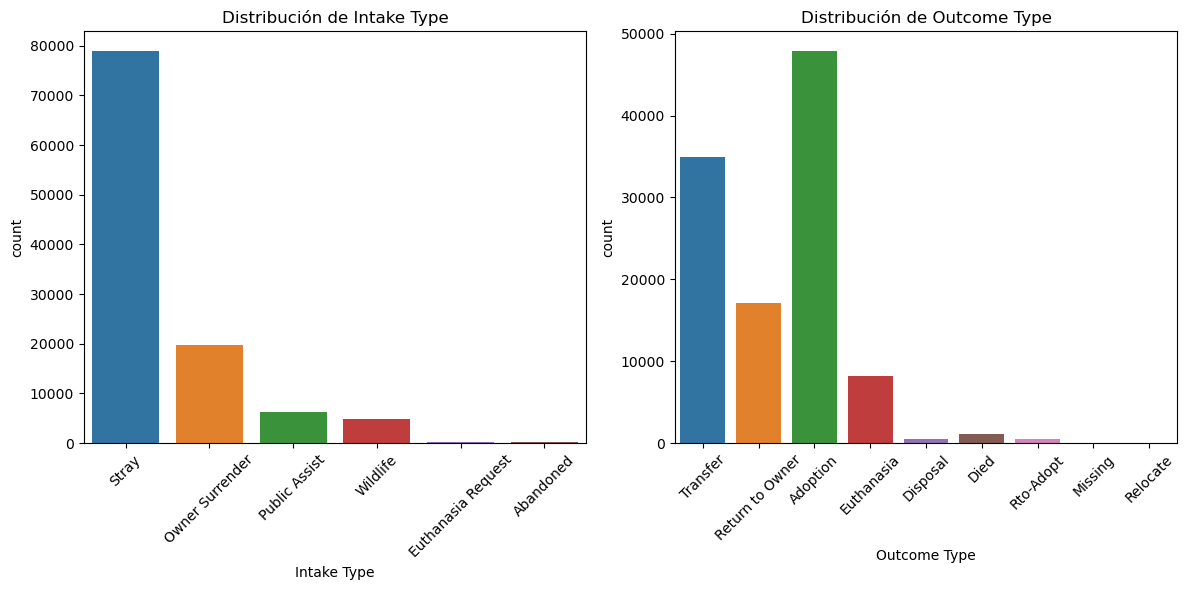

Outcome Type        Adoption  Died  Disposal  Euthanasia  Missing  Relocate  \
Intake Type                                                                   
Abandoned                132     1         2           4        0         0   
Euthanasia Request        10     3         2         191        0         0   
Owner Surrender        11876   142        13         634        8         0   
Public Assist            967    46        55         350        0         0   
Stray                  34902   801       110        2714       49         8   
Wildlife                   7   137       382        4285        2        13   

Outcome Type        Return to Owner  Rto-Adopt  Transfer  
Intake Type                                               
Abandoned                        26          1        88  
Euthanasia Request                9          0        30  
Owner Surrender                1007        145      5968  
Public Assist                  3952         42       943  
Stray        

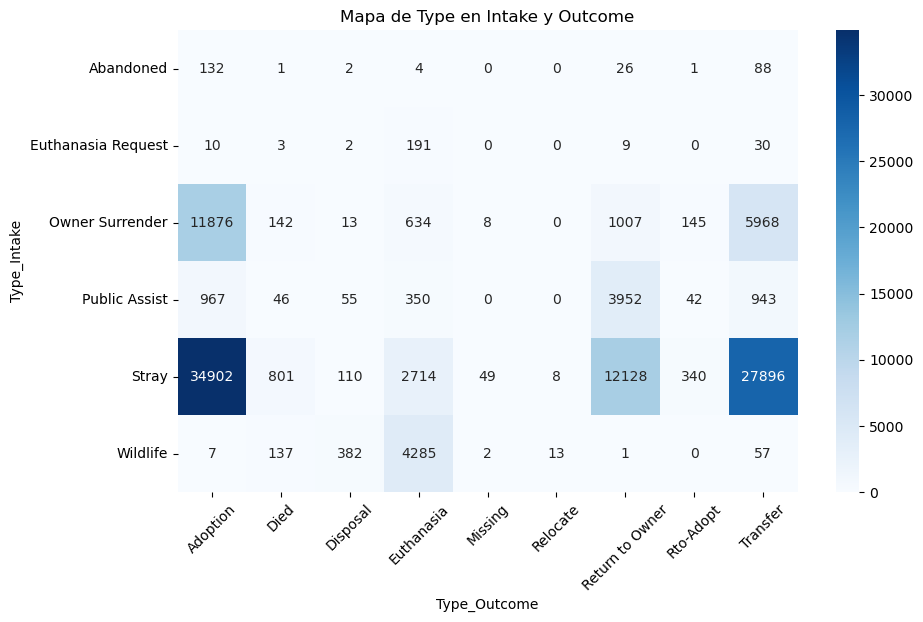

In [3]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=data, x='Intake Type')
plt.title('Distribución de Intake Type')
plt.xlabel('Intake Type')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(data=data, x='Outcome Type')
plt.title('Distribución de Outcome Type')
plt.xlabel('Outcome Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Crear una tabla de contingencia
contingency_table = pd.crosstab(data['Intake Type'], data['Outcome Type'])

# Mostrar la tabla de contingencia
print(contingency_table)

from scipy.stats import chi2_contingency

# Calcular la prueba de Chi-Cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2: {chi2}")
print(f"P-Value: {p}")

if p < 0.05:
    print("Existe una relación significativa entre Type_Intake y Type_Outcome.")
else:
    print("No hay una relación significativa entre Type_Intake y Type_Outcome.")
    
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, cmap='Blues', fmt='d')
plt.title('Mapa de Type en Intake y Outcome')
plt.xlabel('Type_Outcome')
plt.ylabel('Type_Intake')
plt.xticks(rotation=45)
plt.show()

In [4]:

Intakes_cantidad = data['Intake Type'].value_counts()
Outcome_cantidad = data['Outcome Type'].value_counts()

print(Intakes_cantidad)
print(Outcome_cantidad)

wildlife_df = data[data['Intake Type'] == 'Wildlife']

# Calcula la cantidad de animales por cada Intake Condition
intake_condition_counts = wildlife_df['Intake Condition'].value_counts()

# Calcula el porcentaje de cada Intake Condition
intake_condition_percentages = (intake_condition_counts / intake_condition_counts.sum()) * 100

print("Porcentaje de animales por cada Intake Condition (Intake Type: Wildlife):")
print(intake_condition_percentages)

Stray                 78955
Owner Surrender       19795
Public Assist          6356
Wildlife               4889
Abandoned               255
Euthanasia Request      245
Name: Intake Type, dtype: int64
Adoption           47894
Transfer           34982
Return to Owner    17123
Euthanasia          8178
Died                1130
Disposal             564
Rto-Adopt            528
Missing               59
Relocate              21
Name: Outcome Type, dtype: int64
Porcentaje de animales por cada Intake Condition (Intake Type: Wildlife):
Normal     54.162405
Sick       27.244835
Injured    17.467785
Nursing     1.002250
Other       0.081816
Feral       0.020454
Aged        0.020454
Name: Intake Condition, dtype: float64


In [6]:
### Algoritmos Predictivos y Descriptivos

#1. **Regresión Logística** para predecir si un animal será adoptado.

# Filtrar las filas donde el Outcome Type es 'Adoption' o 'Other'
data_filtered = data[(data['Outcome Type'] == 'Adoption') | (data['Outcome Type'] == 'Return to Owner')]

# Convertir Outcome Type a binario: 1 para 'Adoption', 0 para 'Other'
data_filtered['Outcome Type'] = data_filtered['Outcome Type'].apply(lambda x: 1 if x == 'Adoption' else 0)

# Seleccionar características relevantes (puedes ajustar esto según los datos disponibles)
features = ['Animal Type_Intake', 'Age upon Intake', 'Breed_Intake', 'Color_Intake', 'Sex upon Intake']
X = pd.get_dummies(data_filtered[features], drop_first=True)  # Convertir variables categóricas a dummy variables
y = data_filtered['Outcome Type']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo de regresión logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Obtener los coeficientes del modelo
coefficients = pd.DataFrame(model.coef_[0], X.columns, columns=['Coefficient'])
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
print(coefficients)


C:\Users\ALEJA\AppData\Local\Temp\ipykernel_2516\3585591760.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Outcome Type'] = data_filtered['Outcome Type'].apply(lambda x: 1 if x == 'Adoption' else 0)


Confusion Matrix:
[[ 2127  2999]
 [ 1341 13039]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.41      0.49      5126
           1       0.81      0.91      0.86     14380

    accuracy                           0.78     19506
   macro avg       0.71      0.66      0.68     19506
weighted avg       0.76      0.78      0.76     19506

                          Coefficient
Age upon Intake_4 weeks      2.404200
Age upon Intake_5 weeks      1.982039
Age upon Intake_3 days       1.925697
Age upon Intake_2 days       1.786964
Age upon Intake_1 month      1.634404
...                               ...
Age upon Intake_20 years    -2.356846
Age upon Intake_17 years    -2.397158
Breed_Intake_Bullmastiff    -2.440540
Age upon Intake_16 years    -2.597041
Sex upon Intake_Unknown     -3.022780

[2784 rows x 1 columns]


In [7]:
# Entrenar un modelo de Random Forest para comparar
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Obtener la importancia de las características
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Imprimir la importancia de las características
for i in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[i]]}: {importances[indices[i]]:.4f}")

Sex upon Intake_Neutered Male: 0.0533
Sex upon Intake_Spayed Female: 0.0331
Animal Type_Intake_Dog: 0.0250
Age upon Intake_1 month: 0.0229
Animal Type_Intake_Cat: 0.0221
Sex upon Intake_Intact Male: 0.0207
Age upon Intake_2 months: 0.0158
Breed_Intake_Domestic Shorthair Mix: 0.0158
Age upon Intake_2 years: 0.0131
Breed_Intake_Pit Bull Mix: 0.0123
Age upon Intake_3 years: 0.0120
Color_Intake_Black/White: 0.0119
Age upon Intake_1 year: 0.0112
Breed_Intake_Chihuahua Shorthair Mix: 0.0109
Age upon Intake_4 years: 0.0106
Age upon Intake_5 years: 0.0102
Breed_Intake_Labrador Retriever Mix: 0.0100
Age upon Intake_7 years: 0.0088
Age upon Intake_6 years: 0.0087
Color_Intake_Black: 0.0086
Age upon Intake_8 years: 0.0078
Age upon Intake_10 years: 0.0077
Color_Intake_White/Black: 0.0076
Color_Intake_Brown/White: 0.0076
Color_Intake_White: 0.0076
Color_Intake_Tan/White: 0.0071
Color_Intake_Brown: 0.0070
Breed_Intake_German Shepherd Mix: 0.0069
Age upon Intake_9 years: 0.0066
Color_Intake_Black/Bro